In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_original = pd.read_csv("données sans doublon.csv")
df = df_original[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]

df = df[df['charges'] < 49000]

display(df)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


___
MODELE AVEC PIPELINE
___

In [77]:
df_original = pd.read_csv("data_cleaned_cheated.csv")
df = df_original[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'charges_group_cheat','bmi_category']]

# df.loc[:, 'charges_group'] = np.where(df['smoker'] == 0, 1,
#                                       np.where(df['bmi'] >= 30, 3,
#                                                np.where(df['sex'] == 0, 2,
#                                                         np.where(df['age'] < 22, 1, 3))))
df.loc[:, 'charges_group'] = np.where(df['smoker'] == 0, 1,
                                      np.where(df['bmi'] >= 30, 3,
                                               2))
df['have_children'] = np.where(df['children'] > 0, 1, 0)

# nettoyage
df = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'charges_group', 'have_children','bmi_category']]

display(df.head())

,age,sex,bmi,children,smoker,region,charges,charges_group,have_children,bmi_category
0,19,1,27.900,0,1,southwest,16884.92400,2,0,Surpoids
1,18,0,33.770,1,0,southeast,1725.55230,1,1,Obésité modérée
2,28,0,33.000,3,0,southeast,4449.46200,1,1,Obésité modérée
3,33,0,22.705,0,0,northwest,21984.47061,1,0,Poids normal
4,32,0,28.880,0,0,northwest,3866.85520,1,0,Surpoids


In [78]:
from sklearn.model_selection import train_test_split # pour diviser le jeu de données initial en 1 jeu d'entrainement (X_train, y_train) et un jeu de test (X_test, y_test)
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
import joblib
from statsmodels.formula.api import ols
import statsmodels.api as sm

df = pd.read_csv("données sans doublon.csv")

y = df[['charges']]

X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
# X['smoker_bmi'] = X['smoker'] * X['bmi']
# X['smoker_age'] = X['smoker'] * X['age']
# X['smoker_children'] = X['smoker'] * X['children']
# display(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

numerical_features = make_column_selector(dtype_include=np.number) # plutôt que : numerical_features = ['age', 'bmi', 'children']
categorical_features = make_column_selector(dtype_exclude=np.number) # plutôt que : categorical_features = ['region']

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary'))

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                       (categorical_pipeline, categorical_features))

preprocessor = make_pipeline(preprocessor, PolynomialFeatures())

print("##################################################")
print("##################################################")
print("##################################################")
# AVEC GRID SEARCH
# Meilleurs hyperparamètres :  {'lassocv__alphas': [2, 1, 1, 1, 1, 1, 1, 1], 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}
# 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}

model = make_pipeline(preprocessor, LassoCV(alphas=[2, 1, 1, 1, 1, 1, 1, 1], cv=3, eps=0.1, n_alphas=100, random_state=42))
model.fit(X_train, y_train)
print("Avec GRID >", round(model.score(X_test, y_test)*100, 2))
model = make_pipeline(preprocessor, LassoCV(random_state=42))

# SANS GRID SEARCH
model.fit(X_train, y_train)
print("Premier modèle >", round(model.score(X_test, y_test)*100, 2))

# sauvegarde du meilleur modèle
joblib.dump(model, "model.sav")

# distance de cook
# n = X_train.shape[0]
# p = X_train.shape[1]

# X_transformed = preprocessor.fit_transform(X_train)
# col_name = preprocessor.get_feature_names_out()

# X_transformed = pd.DataFrame(data=X_transformed, columns=col_name, index=y_train.index)

# X_s = sm.add_constant(X_transformed)
# model = sm.OLS(y_train, X_s)
# results = model.fit()
# display(results.summary())





# GRID SEARCH
if True == False:
    param_grid = {
        'lassocv__eps': [10**-x for x in range(1,6)],
        'lassocv__n_alphas': [100 * x for x in range(1,4)],
        'lassocv__alphas': [[1,1,1,1,1,1,1,1],
                            [2,1,1,1,1,1,1,1],
                            [1,2,1,1,1,1,1,1],
                            [1,1,2,1,1,1,1,1],
                            [1,1,1,2,1,1,1,1],
                            [1,1,1,1,2,1,1,1],
                            [1,1,1,1,1,2,1,1],
                            [1,1,1,1,1,1,2,1],
                            [1,1,1,1,1,1,1,2]],
        'lassocv__cv': [x for x in range(3,8)],
        'lassocv__random_state': [42]
    }
    grid_search = GridSearchCV(model, param_grid)
    # Entraînement du modèle avec recherche de grille
    grid_search.fit(X_train, y_train)

    print("Meilleurs hyperparamètres : ", grid_search.best_params_)
    # grid_search.predict(X_test))

##################################################
##################################################
##################################################
Avec GRID > 89.97


/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Premier modèle > 90.19


In [79]:
# X_transformed

0.0035211267605633804


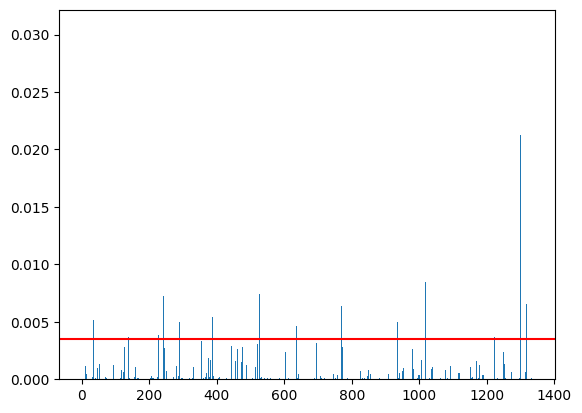

In [80]:
analyse = X_train.copy()
analyse['cook_distance'] = results.get_influence().cooks_distance[0]
analyse

plt.bar(analyse.index, analyse['cook_distance'])
plt.axhline(4/analyse.shape[0], color='red')

len(analyse[analyse['cook_distance'] > 0.0035])
print(4/analyse.shape[0])

In [81]:
X_train_cook = X_train[~(analyse['cook_distance'] > 4/analyse.shape[0])]
y_train_cook = y_train[~(analyse['cook_distance'] > 4/analyse.shape[0])]

# numerical_features = make_column_selector(dtype_include=np.number) # plutôt que : numerical_features = ['age', 'bmi', 'children']
# categorical_features = make_column_selector(dtype_exclude=np.number) # plutôt que : categorical_features = ['region']

# numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
# categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
#                                        (categorical_pipeline, categorical_features))


print("##################################################")
print("##################################################")
print("##################################################")
# AVEC GRID SEARCH
# Meilleurs hyperparamètres :  {'lassocv__alphas': [2, 1, 1, 1, 1, 1, 1, 1], 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}
# 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}

model = make_pipeline(preprocessor, LassoCV(alphas=[2, 1, 1, 1, 1, 1, 1, 1], cv=3, eps=0.1, n_alphas=100, random_state=42))
model.fit(X_train_cook, y_train_cook)
print("Avec GRID >", round(model.score(X_test, y_test)*100, 2))
model = make_pipeline(preprocessor, LassoCV(random_state=42))

# SANS GRID SEARCH
model.fit(X_train_cook, y_train_cook)
print("Premier modèle >", round(model.score(X_test, y_test)*100, 2))

data = [['19','female','27.9','0','yes','southwest']]
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
df = pd.DataFrame(data, columns=columns)
print("prédiction >>>",model.predict(df))

# sauvegarde du meilleur modèle
joblib.dump(model, "model.sav")

##################################################
##################################################
##################################################
Avec GRID > 90.32


/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Premier modèle > 90.57
prédiction >>> [22467.8521349]


['model.sav']

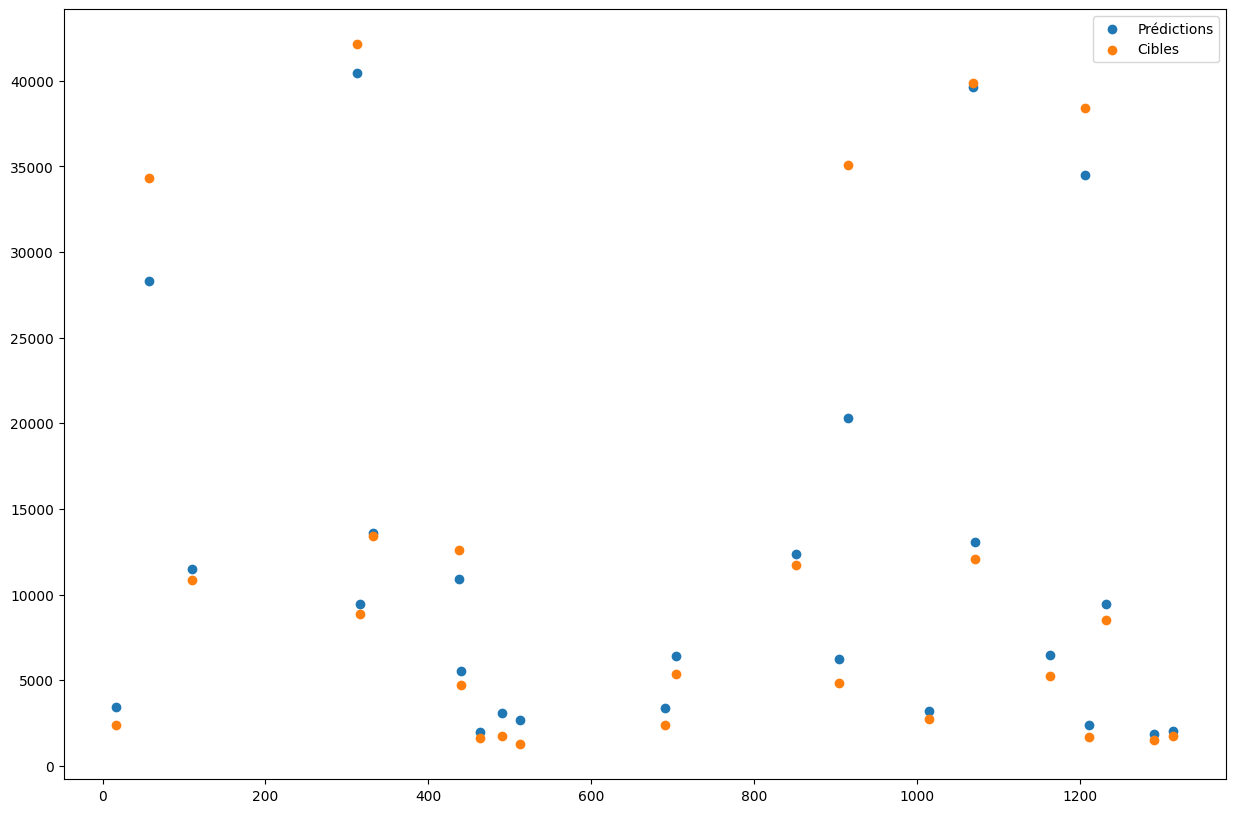

In [82]:
nb_val = 25
X_test = X_test[:nb_val]
y_test = y_test[:nb_val]
x_model = model.predict(X_test[:nb_val])

plt.figure(figsize=(15, 10))
plt.scatter(X_test.index, x_model, label='Prédictions')
plt.scatter(X_test.index, y_test, label='Cibles')
plt.legend()
